
Reinforcement Learning (DQN) tutorial
=====================================
**Author**: `Adam Paszke <https://github.com/apaszke>`_


This tutorial shows how to use PyTorch to train a Deep Q Learning (DQN) agent
on the CartPole-v0 task from the `OpenAI Gym <https://gym.openai.com/>`__.

**Task**

The agent has to decide between two actions - moving the cart left or
right - so that the pole attached to it stays upright. You can find an
official leaderboard with various algorithms and visualizations at the
`Gym website <https://gym.openai.com/envs/CartPole-v0>`__.

.. figure:: /_static/img/cartpole.gif
   :alt: cartpole

   cartpole

As the agent observes the current state of the environment and chooses
an action, the environment *transitions* to a new state, and also
returns a reward that indicates the consequences of the action. In this
task, the environment terminates if the pole falls over too far.

The CartPole task is designed so that the inputs to the agent are 4 real
values representing the environment state (position, velocity, etc.).
However, neural networks can solve the task purely by looking at the
scene, so we'll use a patch of the screen centered on the cart as an
input. Because of this, our results aren't directly comparable to the
ones from the official leaderboard - our task is much harder.
Unfortunately this does slow down the training, because we have to
render all the frames.

Strictly speaking, we will present the state as the difference between
the current screen patch and the previous one. This will allow the agent
to take the velocity of the pole into account from one image.

**Packages**


First, let's import needed packages. Firstly, we need
`gym <https://gym.openai.com/docs>`__ for the environment
(Install using `pip install gym`).
We'll also use the following from PyTorch:

-  neural networks (``torch.nn``)
-  optimization (``torch.optim``)
-  automatic differentiation (``torch.autograd``)
-  utilities for vision tasks (``torchvision`` - `a separate
   package <https://github.com/pytorch/vision>`__).




In [1]:
import math
import random
import time
import win32gui
import numpy as np
import matplotlib.pyplot as plt
import mss
import mss.tools
from collections import namedtuple
from PIL import Image, ImageOps

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

from pynput.keyboard import Key, Controller

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

# Define RL environment for the game window

In [2]:
class GameEnv:
    def __init__(self, windowName, inputInterval):
        self.gameBbox = self.getWindowBbox(windowName)
        self.capper = mss.mss()
        self.capNum = 0
        self.downsamplingMethod = Image.NEAREST
        self.normTransform = self.getNormTransform()        
        
        self.captureWindow = None
        self.prevGoldPixels = None
        
        self.keyboard = Controller()
        self.keyCodes = {0:Key.up, 1:Key.right, 2:Key.down, 3:Key.left}
        self.inputInterval = inputInterval
        
        
    def getWindowBbox(self, windowName):
        gameWindow = win32gui.FindWindow(None, windowName)
        if gameWindow == 0:
            print("Could not find game window for \"" + windowName + "\". Exiting.")
            exit()
        
        bbox = list(win32gui.GetWindowRect(gameWindow))
        # fix idiosyncrasies of win32gui window rect acquisition
        bbox[0] += 8
        bbox[1] += 31
        width = bbox[2]-bbox[0]
        height = bbox[3]-bbox[1]
        # return a 'monitor' object in the format that the mss library wants
        return {'top': bbox[1], 'left': bbox[0], 'width': width-8, 'height': height-8}
    
    def getNormTransform(self):
        meanImage = np.load("data/stats/dsetMean.npy")
        stdImage = np.load("data/stats/dsetStd.npy")
        channelMeans = meanImage.transpose((2,0,1)).mean(axis=(1,2)) / 255
        channelStds = meanImage.transpose((2,0,1)).std(axis=(1,2)) / 255

        return transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(channelMeans, channelStds)
                ])
    
    def quickRestart(self):
        for key in [Key.esc, Key.up, Key.up, Key.up, Key.right]:
            self.keyboard.press(key)
            self.keyboard.release(key)
            time.sleep(0.1)
        time.sleep(2)
    
    def reset(self):
        self.quickRestart()
        initScreen, initGoldPixels, lvlDone, heartPixels = self.getScreenInfo()
        self.prevGoldPixels = initGoldPixels
        self.prevHeartPixels = heartPixels
        self.captureWindow = [initScreen for _ in range(4)]
        
        tensors = [self.normTransform(cap).unsqueeze(0) for cap in self.captureWindow]
        state = torch.cat((tensors[0],tensors[1],tensors[2],tensors[3]), dim=1)
        return state.to(device=device)
        
    def getScreenInfo(self):
        # capture screen and downscale to 180x180
        self.capNum += 1
        screenCap = self.capper.grab(self.gameBbox)
        img = Image.frombytes('RGB', screenCap.size, screenCap.bgra, 'raw', 'BGRX')
        heartPixels = []
        
        padded = ImageOps.expand(img, (30,38,26,18))
        resized = padded.resize((360,360), self.downsamplingMethod)
        final = resized.resize((180,180), self.downsamplingMethod)
        # check for reward indicators
        goldPixels = np.array(final.crop((158,11,170,17))) == 255 # white pixels of gold meter in top right
        levelDone = np.array(final.crop((173,174,174,176))).sum() != 1530
        for pixelCoord in [121,125,134,138]:
            heartPixels.append(np.array(final.crop((pixelCoord,12,pixelCoord+1,13))).sum())

        return (final, goldPixels.astype(int), levelDone, heartPixels)
    
    def step(self, action):
        done = False
        reward = 0
        
        # carry out action
        keyPress = self.keyCodes[action]
        self.keyboard.press(keyPress)
        self.keyboard.release(keyPress)
        
        # wait, then get new game capture
        time.sleep(self.inputInterval)
        screen, goldPixels, lvlDone, heartPixels = self.getScreenInfo()
        
        if lvlDone: # wait a bit then recheck the screen, helps prevent false level finishes
            time.sleep(1)
            screen, goldPixels, lvlDone, heartPixels = self.getScreenInfo()
             
        # check if got reward
        if np.sum(np.abs(goldPixels - self.prevGoldPixels)) != 0: # gold value changed
            reward += 10
        if lvlDone: # beat level 1
            reward += 400
            done = True
            
        # check for damage or dead
        for heartIndex, heartPixel in enumerate(heartPixels):
            if self.prevHeartPixels[heartIndex] != 115 and heartPixel == 115:
                reward -= 10
#                 print ("lost heart {}. penalty applied.".format(heartIndex))
        if heartPixels[0] == 115:
            done = True
            
        # update state variables
        self.prevGoldPixels = goldPixels
        self.prevHeartPixels = heartPixels
        self.captureWindow.pop()
        self.captureWindow.insert(0, screen)
        
        tensors = [self.normTransform(cap).unsqueeze(0) for cap in self.captureWindow]
        state = torch.cat((tensors[0],tensors[1],tensors[2],tensors[3]), dim=1)
        state = state.to(device=device)
        
        return (state, reward, done)

Replay Memory
-------------

We'll be using experience replay memory for training our DQN. It stores
the transitions that the agent observes, allowing us to reuse this data
later. By sampling from it randomly, the transitions that build up a
batch are decorrelated. It has been shown that this greatly stabilizes
and improves the DQN training procedure.

For this, we're going to need two classses:

-  ``Transition`` - a named tuple representing a single transition in
   our environment
-  ``ReplayMemory`` - a cyclic buffer of bounded size that holds the
   transitions observed recently. It also implements a ``.sample()``
   method for selecting a random batch of transitions for training.




In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Input extraction
^^^^^^^^^^^^^^^^

The code below are utilities for extracting and processing rendered
images from the environment. It uses the ``torchvision`` package, which
makes it easy to compose image transforms. Once you run the cell it will
display an example patch that it extracted.




Training
--------

Hyperparameters and utilities
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
This cell instantiates our model and its optimizer, and defines some
utilities:

-  ``select_action`` - will select an action accordingly to an epsilon
   greedy policy. Simply put, we'll sometimes use our model for choosing
   the action, and sometimes we'll just sample one uniformly. The
   probability of choosing a random action will start at ``EPS_START``
   and will decay exponentially towards ``EPS_END``. ``EPS_DECAY``
   controls the rate of the decay.
-  ``plot_durations`` - a helper for plotting the durations of episodes,
   along with an average over the last 100 episodes (the measure used in
   the official evaluations). The plot will be underneath the cell
   containing the main training loop, and will update after every
   episode.




In [4]:
BATCH_SIZE = 64 #128
GAMMA = 0.99 #0.999
EPS_START = 0.8
EPS_END = 0.05
EPS_DECAY = 9000 #200
TARGET_UPDATE = 20

from cloningCNN import CloningCNN
policy_net = CloningCNN('deeper', dropout=0.5, inChannels=12).to(device)
policy_net.load_state_dict(torch.load('models/DeeperQuadsVal79.pt'))
target_net = CloningCNN('deeper', dropout=0.5, inChannels=12).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=5e-4)
memory = ReplayMemory(8000)

steps_done = 0

def select_action(state, verbose=False):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            scores = policy_net(state)
            if verbose:
                print(scores)
            return scores.max(1)[1].view(1, 1)   
    else:
        return torch.tensor([[random.randrange(4)]], device=device, dtype=torch.long)


Training loop
^^^^^^^^^^^^^

Finally, the code for training our model.

Here, you can find an ``optimize_model`` function that performs a
single step of the optimization. It first samples a batch, concatenates
all the tensors into a single one, computes $Q(s_t, a_t)$ and
$V(s_{t+1}) = \max_a Q(s_{t+1}, a)$, and combines them into our
loss. By defition we set $V(s) = 0$ if $s$ is a terminal
state. We also use a target network to compute $V(s_{t+1})$ for
added stability. The target network has its weights kept frozen most of
the time, but is updated with the policy network's weights every so often.
This is usually a set number of steps but we shall use episodes for
simplicity.




In [5]:
def optimize_model():
    if len(memory) < BATCH_SIZE * 6:
        return

    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see http://stackoverflow.com/a/19343/3343043 for
    # detailed explanation).
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s.to(device=device) for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state).to(device=device)
    action_batch = torch.cat(batch.action).to(device=device)
    reward_batch = torch.cat(batch.reward).to(device=device)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    temp = next_state_values * GAMMA
    expected_state_action_values = (temp) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

Below, you can find the main training loop. At the beginning we reset
the environment and initialize the ``state`` Tensor. Then, we sample
an action, execute it, observe the next screen and the reward (always
1), and optimize our model once. When the episode ends (our model
fails), we restart the loop.

Below, `num_episodes` is set small. You should download
the notebook and run lot more epsiodes.




In [6]:
windowName= "Crypt of the NecroDancer"
env = GameEnv(windowName, 0.36)

num_episodes = 102
rewardsOverTime = []
runningReward = 0
modelsFolder = "models/normal/DQN_deeperquads_preinit_tweaked"

In [7]:
print("Move the windows taskbar!")
time.sleep(4) # activate the game window during this

for i_episode in range(num_episodes):
    # Initialize the environment and state
    state = env.reset()
    t, timeSinceReward, totalReward = 0, 0, 0
    while timeSinceReward < 80:  # prevent agent from jumping around aimlessly
        # Select and perform an action
        action = select_action(state, verbose=(t%40==0))
        next_state, reward, done = env.step(action.item())
        reward = torch.tensor([reward], device=device, dtype=torch.float32)
        if reward.item() != 0:
            timeSinceReward = 0
            totalReward += reward.item()
        timeSinceReward += 1
        t += 1
        
        aborted = win32gui.GetWindowText(win32gui.GetForegroundWindow()) != windowName
        if aborted:
            break
        
        # Store the transition in memory
        memory.push(state.cpu(), action.cpu(), next_state.cpu(), reward.cpu())
        # Move to the next state
        state = next_state
        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            break
    if aborted:
        break
    rewardsOverTime.append(totalReward)
    runningReward = runningReward * 0.95 + totalReward * 0.05
    print("\nEpisode {} - Reward {}, Average Reward {}".format(i_episode, totalReward, runningReward))

    
    # Update the target network
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
        torch.save(policy_net.state_dict(), "{}/{}.pt".format(modelsFolder, i_episode))

print('Complete')

Move the windows taskbar!
tensor([[-0.7260,  0.5436,  0.4994, -0.4162]], device='cuda:0')
tensor([[ 2.9466, -1.1698,  0.0540,  0.8503]], device='cuda:0')

Episode 0 - Reward 10.0, Average Reward 0.5
tensor([[-1.0892, -0.9942,  1.7458, -6.3779]], device='cuda:0')

Episode 1 - Reward -30.0, Average Reward -1.025

Episode 2 - Reward 0, Average Reward -0.9737499999999999

Episode 3 - Reward -30.0, Average Reward -2.4250625

Episode 4 - Reward 80.0, Average Reward 1.6961906249999998
tensor([[ 1.4267,  0.5448,  1.8182,  1.3433]], device='cuda:0')

Episode 5 - Reward 0, Average Reward 1.6113810937499997

Episode 6 - Reward -20.0, Average Reward 0.5308120390624997
tensor([[ 1.4875,  1.2803,  2.0815,  1.8830]], device='cuda:0')

Episode 7 - Reward -10.0, Average Reward 0.0042714371093747205

Episode 8 - Reward 0, Average Reward 0.004057865253905985
tensor([[ 1.8108,  1.2823,  2.5645,  1.5410]], device='cuda:0')

Episode 9 - Reward -10.0, Average Reward -0.4961450280087893

Episode 10 - Reward -

tensor([[ 3.1644,  2.9543,  3.6516,  3.2315]], device='cuda:0')

Episode 63 - Reward 400.0, Average Reward 25.61717852358496

Episode 64 - Reward -30.0, Average Reward 22.836319597405712
tensor([[ 2.7952,  3.2747,  5.0074,  3.1963]], device='cuda:0')
tensor([[ 3.3192,  3.3976,  3.3302,  3.2338]], device='cuda:0')

Episode 65 - Reward 10.0, Average Reward 22.194503617535425
tensor([[ 3.4485,  2.1711,  6.0645,  2.7151]], device='cuda:0')
tensor([[ 5.7929,  5.6700,  5.6703,  5.8646]], device='cuda:0')

Episode 66 - Reward 10.0, Average Reward 21.584778436658652

Episode 67 - Reward -30.0, Average Reward 19.00553951482572

Episode 68 - Reward -10.0, Average Reward 17.555262539084435
tensor([[ 4.5947,  4.0861,  5.9285,  4.0981]], device='cuda:0')

Episode 69 - Reward -20.0, Average Reward 15.677499412130214
tensor([[ 2.9604,  2.9248,  4.5666,  2.8858]], device='cuda:0')
tensor([[ 5.2986,  5.7635,  6.2061,  5.6607]], device='cuda:0')

Episode 70 - Reward -20.0, Average Reward 13.893624441523

In [8]:
with open("{}/rewards.txt".format(modelsFolder), "w+") as rewardsFile:
    for reward in rewardsOverTime:
        rewardsFile.write("{}\n".format(reward))

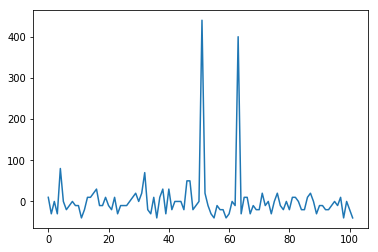

In [9]:
plt.plot(rewardsOverTime)

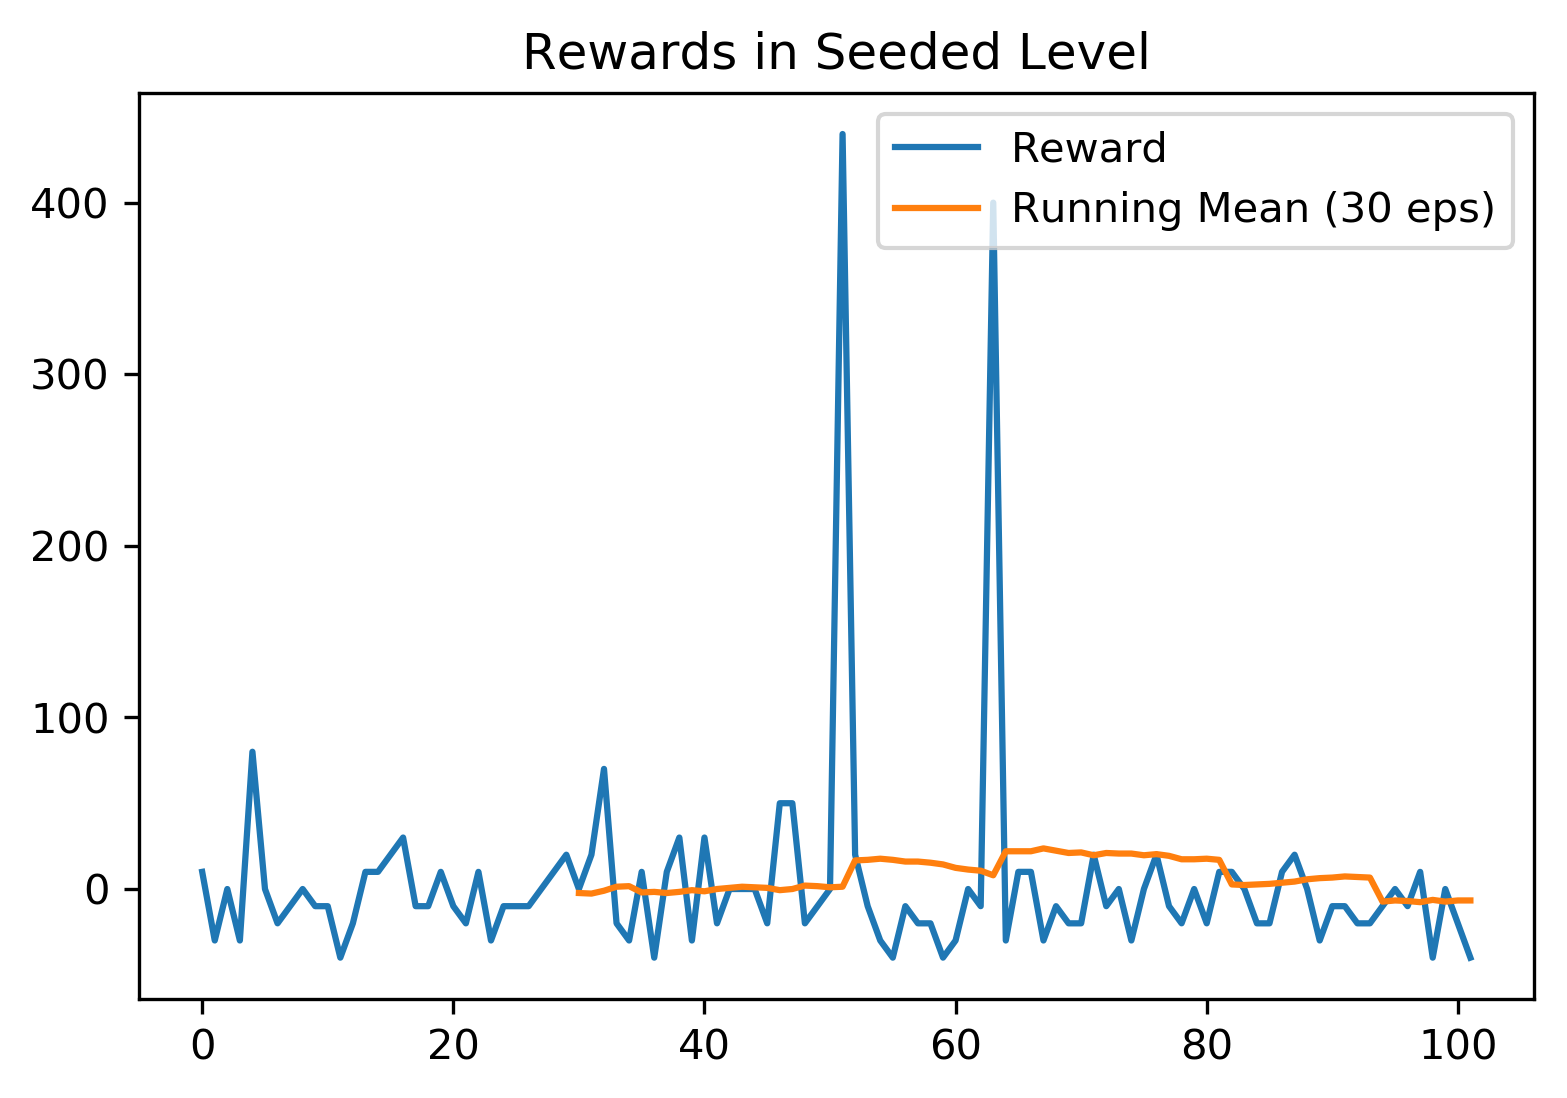

In [12]:
avgs = []
N = 30
for i in range(N):
    avgs.append(None)
for i in range(N, len(rewardsOverTime)):
    avgs.append(sum(rewardsOverTime[i-N:i])/N)
plt.figure(dpi=300)
plt.plot(rewardsOverTime, label="Reward")
plt.plot(avgs, label="Running Mean (30 eps)")
plt.title("Rewards in Seeded Level")
plt.legend(loc='upper right')
# plt.axis([0, 100, -40, 130])
plt.savefig('demos/normal/DQN_deeperquads_preinit_tweaked.png')
plt.show()

# Run the model greedily after training.

In [11]:
# EPS_START = 0
# EPS_END = 0
# # policy_net.load_state_dict(torch.load('models/DQN_deeperquads_preinit/210.pt'))

# print("Move the windows taskbar!")
# with torch.no_grad():
#     time.sleep(4) # activate the game window during this
#     state = env.reset()
#     while win32gui.GetWindowText(win32gui.GetForegroundWindow()) == windowName: # exit on window unfocus
#         action = select_action(state, verbose=True)
#         state, reward, done = env.step(action.item())
# #         time.sleep(0.4)
#         if reward != 0:
#             print("Got reward {}.".format(reward))
        
# print("Game window no longer active. Exiting.")